<a href="https://colab.research.google.com/github/zeliky/deep-learning-fp/blob/main/final_projectf_finetune_emb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from scipy.io import loadmat
import numpy as np
from PIL import Image,ImageShow
import matplotlib.pyplot as plt
import re
import os
import math
import random
import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Lambda, Flatten, Dense, Dropout,Activation, BatchNormalization,Add, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from keras.regularizers import l2
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.metrics import Mean
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import gc

In [2]:
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
BASE_PATH  = '/gdrive/MyDrive/deep-learning/final-project/data-sets/'
ORIGINAL_IMAGES = BASE_PATH + "0_Images/"
ROTATED_IMAGES = BASE_PATH + "1_ImagesRotated/"
MEDIAN_BW_IMAGES = BASE_PATH + "2_ImagesMedianBW/"
LINES_REMOVED_BW_IMAGES = BASE_PATH + "3_ImagesLinesRemovedBW/"
LINES_REMOVED_IMAGES = BASE_PATH + "4_ImagesLinesRemoved/"
DARK_LINES = BASE_PATH + "5_DataDarkLines/"
SAMPLE_FILE_PATTERN = "lines{}_Page_{}.jpg"
METADATA_PATTERN = "lines{}_Page_{}.mat"
MODEL_CHECKPOINT_PATH = BASE_PATH + "model_checkpoints/"

NUMPY_STORAGE = BASE_PATH + "numpy_storage/{}_train_validation.npz"
ALLOWED_TYPES = [ORIGINAL_IMAGES, ROTATED_IMAGES, MEDIAN_BW_IMAGES, LINES_REMOVED_BW_IMAGES, LINES_REMOVED_IMAGES]
TRAIN_TYPES = [LINES_REMOVED_BW_IMAGES, LINES_REMOVED_IMAGES]
VALIDATE_TYPES = [ORIGINAL_IMAGES]
EMBEDDING_TYPES = [ORIGINAL_IMAGES, LINES_REMOVED_BW_IMAGES]
LINE_SHAPE = (225, 4965)
INPUT_SQUARE = (227, 227)

MODE_TRAIN = 'train'
MODE_VALIDATION = 'validation'
MODE_TEST = 'test'


In [4]:
class MetaData:
  @staticmethod
  def from_mat_data(data):
    metadata = MetaData()
    SCALE_FACTOR = data['SCALE_FACTOR'].flatten()[0]
    peaks_indices = data['peaks_indices'].flatten()
    metadata.min_y  = SCALE_FACTOR * min(peaks_indices)
    metadata.max_y  = SCALE_FACTOR *  max(peaks_indices)
    metadata.peaks_indices = [SCALE_FACTOR*a - metadata.min_y for a in  peaks_indices]
    metadata.index_of_max_in_peak_indices = data['index_of_max_in_peak_indices'].flatten()[0]
    metadata.delta = data['delta'].flatten()[0]
    metadata.top_test_area = data['top_test_area'].flatten()[0] - metadata.min_y
    metadata.bottom_test_area = data['bottom_test_area'].flatten()[0] - metadata.min_y
    metadata.total_lines = len(metadata.peaks_indices)
    return metadata

  def __repr__(self):
    return str(self.__dict__)


In [5]:
class ModelOptions:
    def __init__(self, **kwargs):
        self.num_classes = kwargs.get('num_classes', 10)
        self.batch_size = kwargs.get('batch_size', 100)
        self.image_height = kwargs.get('image_height', 150)
        self.image_width = kwargs.get('image_width', 150)
        self.num_channels = kwargs.get('num_channels', 1)
        self.max_sequence_length = kwargs.get('max_sequence_length', 40)
        self.random_shuffle_amount = kwargs.get('random_shuffle_amount', 5)
        #self.lstm_units = kwargs.get('lstm_units', 5)
        self.max_embedding_samples = kwargs.get('max_embedding_samples', 5)
        self.alpha = kwargs.get('alpha', 0.2)
        self.embedding_dim = kwargs.get('embedding_dim', 128)

    def __repr__(self):
        return str(self.__dict__)

In [6]:
class DataSet:
    def __init__(self):
        self.user_files = {}
        self.metadata = {}
        self._build_index()
        self.reset()

    def reset(self):
        self.images = {}

    def load_image(self, path, user_id):
        bin, id = self.user_files[user_id]
        image_type = self._image_type(path)

        file_name = SAMPLE_FILE_PATTERN.format(bin, id)
        image_path = "{}{}".format(path, file_name)
        image_metadata = self._get_cached_metadata(user_id)
        if image_metadata is None:
            image_metadata = self.image_metadata(user_id)
            self._cache_metadata(user_id, image_metadata)

        user_file = self._get_cached_image(image_type, user_id)
        if user_file is None:
            print('loading image from {}'.format(image_path))
            with open(image_path, 'r') as f:
                im = Image.open(image_path)
                user_file = UserFile(im, image_metadata)
                self._cache_image(image_type, user_id, user_file)
                del im
        return user_file

    def image_metadata(self, user_id):
        bin, id = self.user_files[user_id]
        file_name = METADATA_PATTERN.format(bin, id)
        metadata_path = "{}{}".format(DARK_LINES, file_name)
        # print(metadata_path)
        data = loadmat(metadata_path)
        return MetaData.from_mat_data(data)

    def _image_type(self, path):
        reg = re.search(r'\d+', path)
        return int(reg.group())


    def _build_index(self):
        directory_files = os.listdir(ORIGINAL_IMAGES)
        for idx, fname in enumerate(directory_files):
            pattern = re.search(r'lines(\d+)_Page_(\d+)', fname.replace(BASE_PATH, ''))
            self.user_files[idx] = (pattern.group(1), pattern.group(2))

    def _get_cached_image(self, image_type, user_id):
        if image_type in self.images and user_id in self.images[image_type]:
            return self.images[image_type][user_id]
        return None

    def _cache_image(self, image_type, user_id, image):
        if image_type not in self.images:
            self.images[image_type] = {}
        if user_id not in self.images[image_type]:
            self.images[image_type][user_id] = image

    def _get_cached_metadata(self, user_id):
        if user_id in self.metadata:
            return self.metadata[user_id]
        return None

    def _cache_metadata(self, user_id, metadata: MetaData):
        self.metadata[user_id] = metadata


# -------------------------------------------------------------------------------
#should be kept global so it will be shared by multi processes
full_data_set = DataSet()

In [7]:
class UserFile:
    def __init__(self, im, metadata):
        # image_arr = np.asarray(im.getchannel(0).getdata())

        if im.mode != 'L':
            im = im.convert(mode='L')
        image_arr = np.asarray(im.getchannel(0))
        # image_arr = image_arr.reshape(im.height, im.width)
        # print(image_arr.shape)
        self.data = image_arr[metadata.min_y: metadata.max_y, :]
        self.metadata = metadata

    def get_testing_line(self):
        y_range = (self.metadata.top_test_area, self.metadata.bottom_test_area)
        return self.data[y_range[0]:y_range[1], :]

    def get_test_line_idx(self):
        for i in range(1, self.metadata.total_lines):
            if self.is_test_line(i):
                return i

    def get_all_lines(self, threshold=2000):
        for i in range(1, self.metadata.total_lines):
            yield self.get_line(i)

    def get_line(self, line_idx):
        y_range = (self.metadata.peaks_indices[line_idx - 1:line_idx + 1])
        return self.data[y_range[0]:y_range[1] + 30, :]

    def is_test_line(self, line_idx):
        bounderies = self.metadata.peaks_indices[line_idx - 1:line_idx + 1]
        return abs(int(bounderies[0]) - self.metadata.top_test_area) < 50 and abs(
            int(bounderies[1]) - self.metadata.bottom_test_area) < 50

    def show(self):
        image = Image.fromarray(self.data.astype(np.uint8))
        image.show()


In [8]:
class UserDataset:
    def __init__(self, user_id):
        self.user_id = user_id
        self.train_lines = []
        self.validation_lines = []
        self.all_lines = []
        self.normalized_lines = {}
        self.test_line = None
        self.split_points = {}
        self.min_width = 10
        self.min_colored_pixels = 500 * 255

    def warmup(self, load_types, train_split=0.8, shuffle=True):
        e = ThreadPoolExecutor(max_workers=len(load_types))
        futures = [e.submit(full_data_set.load_image, t, self.user_id) for t in load_types]
        results = [f.result() for f in futures]
        self.split_dataset(train_split, shuffle)

    def split_dataset(self, train_split, shuffle):
        bw_image = full_data_set.load_image(LINES_REMOVED_BW_IMAGES, self.user_id)
        self.train_lines, self.validation_lines = select_train_validation_lines(bw_image, train_split, shuffle)
        self.test_line = bw_image.get_test_line_idx()
        self.all_lines = sorted(self.train_lines + self.validation_lines)

    def get_letters(self, img_path, line_idx, target_size):
        split_points = self._get_characters_split_points(line_idx)
        line = self._get_normalized_line(img_path, line_idx)
        for (x, y, w, h) in split_points:
            img = line[:, x:x + w]
            # print(f"get_letter shape {img.shape}")
            thumbnail = create_thumbnail(img, target_size)
            np_im = np.array(thumbnail, dtype=np.float32) / 255
            np_img = np_im.reshape(target_size[0], target_size[1], 1)
            yield np_img
        return

    def get_line_as_sequence(self, img_path, line_idx, max_sequence_length, target_size):
        sequence = []
        line = self._get_normalized_line(img_path, line_idx)
        split_points = self._get_characters_split_points(line_idx)
        for (x, y, w, h) in split_points:
            img = line[:, x:x + w]
            thumbnail = create_thumbnail(img, target_size)
            np_im = np.array(thumbnail, dtype=np.float32) / 255
            np_img = np_im.reshape(target_size[0], target_size[1], 1)
            sequence.append(np_img)
        return pad_sequence(max_sequence_length, sequence, target_size[0], target_size[1], 1)

    def random_line_generator(self, mode, max_sequence_length, target_size, sample_from_lines_amount=None,
                              sequence_length=None, original_only=False):
        while True:
            types = ALLOWED_TYPES if not original_only else [ORIGINAL_IMAGES]
            img_path = random.choice(types)
            lines = self._get_lines_ids_set(mode)
            if sample_from_lines_amount is None:
                sample_from_lines_amount = random.randint(1, len(lines) - 1)
            #print(f"random_line_generator {sample_from_lines_amount} out of {len(lines)} ")
            selected_lines = random.sample(lines, min(sample_from_lines_amount,len(lines)))
            if sequence_length is None:
                sequence_length = random.randint(int(0.3 * max_sequence_length), max_sequence_length)
            sequence = []
            for _ in range(sequence_length):
                line_idx = random.choice(selected_lines)
                line = self._get_normalized_line(img_path, line_idx)
                split_points = self._get_characters_split_points(line_idx)
                (x, y, w, h) = random.choice(split_points)
                img = line[:, x:x + w]
                thumbnail = create_thumbnail(img, target_size)
                np_im = np.array(thumbnail, dtype=np.float32) / 255
                np_img = np_im.reshape(target_size[0], target_size[1], 1)
                sequence.append(np_img)
            yield pad_sequence(max_sequence_length, sequence, target_size[0], target_size[1], 1)

    def random_letters_generator(self, mode, target_size, random_shuffle_amount=1, allowed_types=ALLOWED_TYPES):
        while True:
            img_path = random.choice(allowed_types)
            lines = self._get_lines_ids_set(mode)
            line_idx = random.choice(lines)
            line = self._get_normalized_line(img_path,line_idx)
            split_points = self._get_characters_split_points(line_idx)
            points_amount = len(split_points)
            if points_amount <= 2: #skip lines with too few examples
               continue
            split_index = random.randint(0, points_amount - 1)
            (x, y, w, h) = split_points[split_index]

            img = line[:, x:x + w]
            thumbnails = [create_thumbnail(img, target_size) for _ in range(random_shuffle_amount)]
            for i, thumbnail in enumerate(thumbnails):
                np_im = np.array(thumbnail, dtype=np.float32) / 255
                np_img = np_im.reshape(target_size[0], target_size[1], 1)
                # print(f"{img_path}: u:{self.user_id} l:{line_idx} x:{x}-{x+w} rand:{i}")
                yield np_img, img_path, line_idx, split_index

    def get_letter(self, img_path, line_idx, split_index, target_size):
        line = self._get_normalized_line(img_path, line_idx)
        split_points = self._get_characters_split_points(line_idx)
        (x, y, w, h) = split_points[split_index]
        img = line[:, x:x + w]
        thumbnail = create_thumbnail(img, target_size)
        np_im = np.array(thumbnail, dtype=np.float32) / 255
        return np_im.reshape(target_size[0], target_size[1], 1)

    def _get_lines_ids_set(self, mode):
        if mode == MODE_TRAIN:
            return self.train_lines
        elif mode == MODE_VALIDATION:
            return self.validation_lines
        return [self.test_line]

    def _get_characters_split_points(self, idx):
        if idx in self.split_points:
            return self.split_points[idx]
        line = self._get_normalized_line(LINES_REMOVED_BW_IMAGES, idx)
        binary = np.where(line > 30, 1, 0).astype('uint8')
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
        dilation = cv2.dilate(binary, rect_kernel, iterations=1)
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        split_points = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > self.min_width:
                sub_img = line[:, x:x + w]
                # print(f"_get_characters_split_points line \t {idx}\t{x}\t{x+w}\t{sub_img.sum()}")
                if sub_img.sum() > self.min_colored_pixels:
                    split_points.append((x, y, w, h))

        self.split_points[idx] = sorted(split_points, key=lambda tup: tup[0])
        # print( self.split_points[idx])
        return self.split_points[idx]

    def _get_normalized_line(self, img_path, line_idx):
        if img_path not in self.normalized_lines:
            self.normalized_lines[img_path] = {}
        if line_idx not in self.normalized_lines:
            user_file = full_data_set.load_image(img_path, self.user_id)
            self.normalized_lines[img_path][line_idx] = normalized_line(user_file.get_line(line_idx))
        return self.normalized_lines[img_path][line_idx]




In [9]:
def image_dots(img_data, threshold=50):
    height, width = img_data.shape
    for i in range(height):
        line = ''
        for j in range(width):
            if img_data[i, j] < threshold:
                line += ' '
            else:
                line += '.'
        print(line)


def show_line(line_data):
    image = Image.fromarray(line_data.astype(np.uint8))
    image.show()


def is_empty_line(line_data, threshold=5000):
    values = line_data.flatten()
    sum = values[values < 50].sum()
    # print("is_empty_line {}".format(sum))
    return sum < threshold


def normalized_line(line_data):
    desired_shape = LINE_SHAPE
    # normalized_data =  (255 - line_data) / 255.0
    normalized_data = (255 - line_data)
    pad_rows = max(0, desired_shape[0] - normalized_data.shape[0])
    pad_cols = max(0, desired_shape[1] - normalized_data.shape[1])

    padded_array = np.pad(normalized_data, ((0, pad_rows), (0, pad_cols)), mode='constant')
    return padded_array


def select_train_validation_lines(user_image, train_split, shuffle):
    rows = []
    for i, line in enumerate(user_image.get_all_lines()):
        idx = i + 1
        if not user_image.is_test_line(idx) and not is_empty_line(line):
            rows.append(idx)
    if shuffle:
        random.shuffle(rows)
    split_idx = int(len(rows) * train_split)
    # print((rows[0:split_idx], rows[split_idx:]))
    return (rows[0:split_idx], rows[split_idx:])


def split_and_shuffle_array(arr, split_points):
    chunks = split_array(arr, split_points)
    np.random.shuffle(chunks)
    shuffled_array = np.concatenate(chunks, axis=1)
    return shuffled_array


def split_array(arr, split_points):
    chunks = []
    start_idx = 0
    for end_idx in split_points:
        chunk = arr[:, start_idx:end_idx]
        chunks.append(chunk)
        start_idx = end_idx
    last_chunk = arr[:, start_idx:]
    chunks.append(last_chunk)
    return chunks


def create_thumbnail(image_array, target_size):
    height, width = image_array.shape
    target_height, target_width = target_size
    org_image = Image.fromarray(image_array)

    random_scale_w = random.uniform(0.8, 1.2)
    random_scale_h = random.uniform(0.8, 1.2)
    random_rotate = random.randint(-15, 15)
    org_image_rs = org_image.resize((int(width * random_scale_w), int(height * random_scale_h)), Image.NEAREST)
    org_image_ro = org_image_rs.rotate(random_rotate, Image.NEAREST, expand=True)

    canvas = Image.new("L", (height, height), 0)
    if width < height:
        left = (height - width) // 2
        top = 0
        canvas.paste(org_image_ro, (left, top))
    else:
        scale_factor = height / width
        s_width = round(scale_factor * width)
        s_height = round(scale_factor * height)
        resized_image = org_image_ro.resize((s_width, s_height), Image.NEAREST)
        left = (height - s_width) // 2
        top = 0
        canvas.paste(resized_image, (left, top))
        del resized_image

    del org_image_rs
    del org_image_ro
    del org_image

    thumbnail = canvas.resize((target_width, target_height), Image.NEAREST)
    return thumbnail


def show_sequence(the_images):
    l = len(the_images)
    dim = math.ceil(math.sqrt(l))
    plt.clf()
    fig, axs = plt.subplots(dim, dim, figsize=(10, 10))
    k = 0
    for i in range(0, dim):
        for j in range(0, dim):
            img = the_images[k]
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
            k += 1
            if k == l:
                plt.show()
                return


def show_triplet(triplets):
    plt.clf()
    fig, axs = plt.subplots(1, 3, figsize=(5, 5))

    for k in range(0, 3):
        img = triplets[k]
        axs[k].imshow(img, cmap='gray')
        axs[k].axis('off')

    plt.show()


def pad_sequence(max_sequence_length, sequence, image_height, image_width, num_channels):
    sequence = np.asarray(sequence)
    padding_size = max_sequence_length - len(sequence)
    if padding_size > 0:
        padding_shape = (padding_size, image_height, image_width, num_channels)
        padding_images = np.zeros(padding_shape)
        padded_sequence = np.concatenate([sequence, padding_images], axis=0)
    else:
        padded_sequence = np.asarray(sequence)
    return padded_sequence


def pad_sequences(max_length, sequences, image_height, image_width, num_channels):
    # Pad sequences to have the same length (pad with zero images)
    padded_sequences = []
    for sequence in sequences:
        seq_len = len(sequence)
        if seq_len == 0:
            continue
        if seq_len > max_length:
            sequence = sequence[:max_length]
            seq_len = len(sequence)

        num_padding = max_length - seq_len
        if num_padding > 0:
            sequence = np.concatenate(
                [sequence, np.zeros((num_padding, image_height, image_width, num_channels))])
        padded_sequences.append(sequence)
    return np.array(padded_sequences)


helpers for training stats
based on https://github.com/CrimyTheBold/tripletloss/blob/master/02%20-%20tripletloss%20MNIST.ipynb

In [ ]:
def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class

    Returns
        probs : array of shape (m,m) containing distances

    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))

    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)

    size_embedding = embeddings.shape[1]

    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)

    return fpr, tpr, thresholds,auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image:
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings

    Returns:
        array of shape (nb_classes,nb_classes)
    '''
    res = np.zeros((nb_classes,nb_classes))

    ref_images = np.zeros((nb_classes,img_rows,img_cols,1))

    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)

    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network,n_iteration):
    interdist = compute_interdist(network)

    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))

    plt.show()

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx

def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]


    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()

In [ ]:
class FinalStopIteration(StopIteration):
    def __init__(self, *args: object) -> None:
        super().__init__(*args)


In [10]:
class BaseLetterGenerator(Sequence):
    MAX_USERS_PER_CHUNK = 10

    def __init__(self, mode, user_ids, options: ModelOptions, load_types):
        self.options = options
        self.all_user_ids = [i for i in user_ids]
        self.id_to_class = {user_id: i for i, user_id in enumerate(user_ids)}
        self.user_ids = []
        self.input_shape = (options.image_height, options.image_width)
        self.random_shuffle_amount = options.random_shuffle_amount
        self.users_ds = {}
        self.generators = {}

        # generator settings.
        self.mode = mode
        self.load_types = load_types
        self.train_split = 0.8
        self.shuffle = True

        self.select_users_chunk()

    def __len__(self):
        return self.options.max_embedding_samples // self.options.batch_size

    def select_users_chunk(self):
        chunk_size = min(len(self.all_user_ids), self.MAX_USERS_PER_CHUNK)
        print(f"select_users_chunk {chunk_size} out of {len(self.all_user_ids)} ")
        self.user_ids = random.sample(self.all_user_ids, chunk_size)
        print(f"selected user_ids {self.user_ids}")

    def on_epoch_end(self):
        global full_data_set
        full_data_set = DataSet()
        self.select_users_chunk()
        self.generators = {}
        print('running GarbageCollector...')
        gc.collect()

    def get_user_ds(self, user_id):
        if user_id not in self.users_ds:
            uds = UserDataset(user_id)
            uds.warmup(self.load_types, self.train_split, self.shuffle)
            self.users_ds[user_id] = uds
        return self.users_ds[user_id]

    def get_letters_generator(self, user_id, is_anchor=False):
        key = f"anc{user_id}" if is_anchor else str(user_id)
        if key not in self.generators:
            # print(f"new generator for {user_id} anchor{is_anchor}")
            uds = self.get_user_ds(user_id)
            self.generators[key] = uds.random_letters_generator(mode=self.mode, target_size=self.input_shape,
                                                                allowed_types=self.load_types,
                                                                random_shuffle_amount=self.random_shuffle_amount)
        return self.generators[key]

    def set_train_split(self, train_split):
        self.train_split = train_split

    def set_shuffle(self, shuffle):
        self.shuffle = shuffle


class LettersGenerator(BaseLetterGenerator):
    def __init__(self, mode, user_ids, options: ModelOptions, total_users):
        super().__init__(mode, user_ids, options, EMBEDDING_TYPES)
        self.total_users = total_users

    def __len__(self):
        lines = 20
        # lines=10
        users = len(self.user_ids)
        letters_per_line = self.options.max_sequence_length
        # letters =30
        random_shuffle_amount = self.options.random_shuffle_amount
        types = len(self.load_types)

        total_batches = (types * lines * users * letters_per_line * random_shuffle_amount) // self.options.batch_size
        # print(f"LettersGenerator __len__ {total_batches}")
        return total_batches

    def __getitem__(self, index):
        batch, labels = [], []
        users_count = len(self.user_ids)
        for s in range(self.options.batch_size):
            user_id = random.choice(self.user_ids)
            # print(f"__getitem__{user_id}")
            letter, _, _, _ = next(self.get_letters_generator(user_id))
            batch.append(letter)
            labels.append(to_categorical(self.id_to_class[user_id], num_classes=self.total_users))
            # print(labels)

        if len(batch) == 0:
            batch = np.zeros((self.options.batch_size, self.options.image_height, self.options.image_width, 1))
            labels = np.zeros((self.options.batch_size,))
        # print(f"LettersGenerator batch: {len(batch)}")
        return np.asarray(batch), np.asarray(labels)


class TripletsGenerator(BaseLetterGenerator):
    def __init__(self, mode, user_ids, options: ModelOptions):
        super().__init__(mode, user_ids, options, EMBEDDING_TYPES)
        self.set_train_split(1)  # it should iterate all rows
        self.set_shuffle(False)

    def __len__(self):
        lines = 20
        users = len(self.user_ids)
        letters_per_line = self.options.max_sequence_length
        random_shuffle_amount = 5

        total_batches = (lines * users * letters_per_line * random_shuffle_amount) // self.options.batch_size
        # print(f"LettersGenerator __len__ {total_batches}")
        return total_batches

    def __getitem__(self, index):
        anchors, positives, negatives = [], [], []
        for _ in range(self.options.batch_size):
            #print(f"__getitem__ {2} out of {len(self.user_ids)} ")
            positive_user, negative_user_id = random.sample(self.user_ids, 2)
            # print(f"TripletsGenerator __getitem__ {positive_user} {negative_user_id} " )
            for triplet in self.get_triplets(positive_user, negative_user_id):
                if triplet is None:
                    #print(f"__getitem__ {2} out of {len(self.user_ids)} ")
                    positive_user, negative_user_id = random.sample(self.user_ids, 2)
                    continue
                anchor, positive, negative = triplet
                anchors.append(anchor)
                positives.append(positive)
                negatives.append(negative)

        batch = [np.asarray(anchors), np.asarray(positives), np.asarray(negatives)]
        return batch, []

    def get_triplets(self, positive_user, negative_user_id):
        anc_letter, img_path, line_idx, split_index = next(self.get_letters_generator(positive_user, True))
        uds = self.get_user_ds(positive_user)
        filtered = list(filter(lambda im_type: im_type != img_path, self.load_types))
        if len(filtered)>0:
            img_path = random.choice(filtered)
        positive_letter = uds.get_letter(img_path, line_idx, split_index, self.input_shape)
        negative_letter, _, _, _ = next(self.get_letters_generator(negative_user_id, False))
        if anc_letter is not None and positive_letter is not None and negative_letter is not None:
            yield anc_letter, positive_letter, negative_letter




Display generators

In [ ]:

user_ids = range(0,200)
num_classes = len(user_ids)

num_epochs = 3

model_options = ModelOptions(
    num_classes=len(user_ids) ,
    batch_size=100,
    image_height=150,
    image_width=150,
    num_channels=1,
    max_sequence_length=40,
    random_shuffle_amount=1,
    lstm_units=15
)
model_options

{'num_classes': 200, 'batch_size': 100, 'image_height': 150, 'image_width': 150, 'num_channels': 1, 'max_sequence_length': 36, 'random_shuffle_amount': 1, 'max_embedding_samples': 5, 'alpha': 0.2, 'embedding_dim': 128}

select_users_chunk 10 out of 200 
selected user_ids [186, 25, 176, 88, 159, 82, 181, 194, 6, 134]
select_users_chunk 10 out of 200 
selected user_ids [161, 88, 6, 148, 58, 97, 66, 150, 53, 29]
select_users_chunk 10 out of 200 
selected user_ids [131, 14, 128, 69, 161, 87, 153, 180, 76, 48]
running GarbageCollector...
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines3_Page_20.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines3_Page_20.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines2_Page_63.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines2_Page_63.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines2_Page_22.jpgloading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines2_Page_22.jpg

loading image from /gdrive/MyDriv

<Figure size 640x480 with 0 Axes>

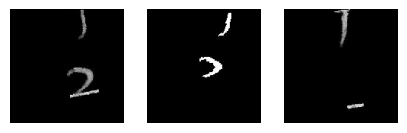

<Figure size 640x480 with 0 Axes>

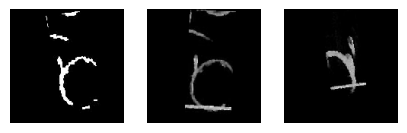

<Figure size 640x480 with 0 Axes>

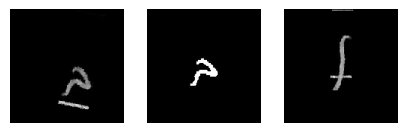

<Figure size 640x480 with 0 Axes>

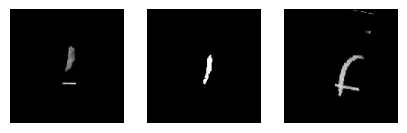

<Figure size 640x480 with 0 Axes>

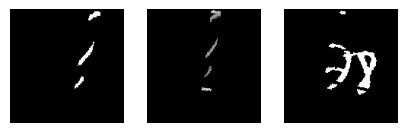

<Figure size 640x480 with 0 Axes>

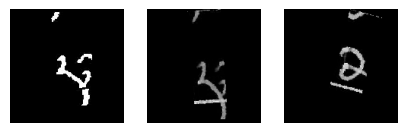

<Figure size 640x480 with 0 Axes>

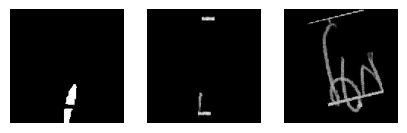

<Figure size 640x480 with 0 Axes>

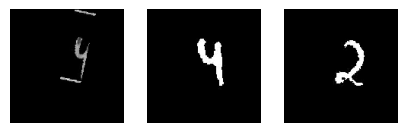

<Figure size 640x480 with 0 Axes>

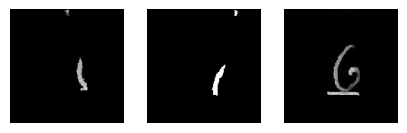

<Figure size 640x480 with 0 Axes>

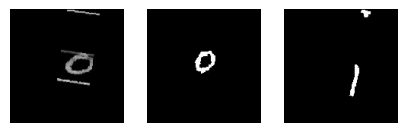

<Figure size 640x480 with 0 Axes>

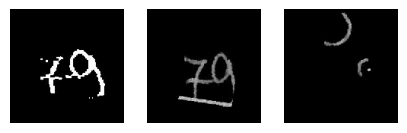

<Figure size 640x480 with 0 Axes>

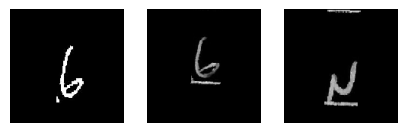

<Figure size 640x480 with 0 Axes>

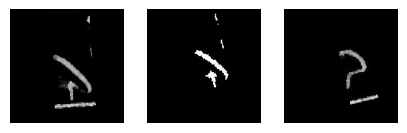

<Figure size 640x480 with 0 Axes>

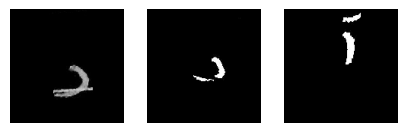

<Figure size 640x480 with 0 Axes>

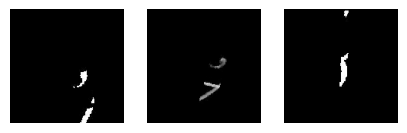

<Figure size 640x480 with 0 Axes>

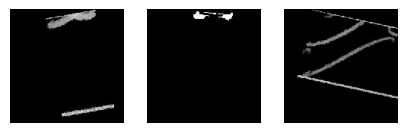

<Figure size 640x480 with 0 Axes>

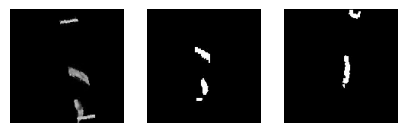

<Figure size 640x480 with 0 Axes>

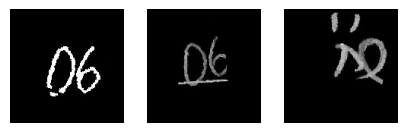

<Figure size 640x480 with 0 Axes>

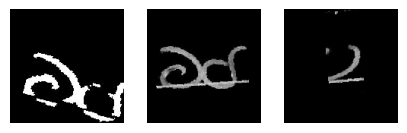

<Figure size 640x480 with 0 Axes>

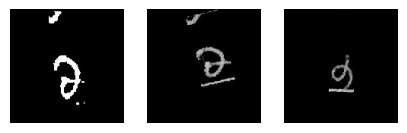

<Figure size 640x480 with 0 Axes>

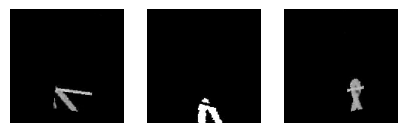

<Figure size 640x480 with 0 Axes>

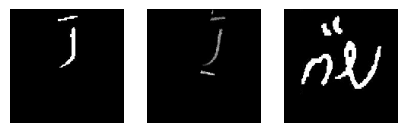

<Figure size 640x480 with 0 Axes>

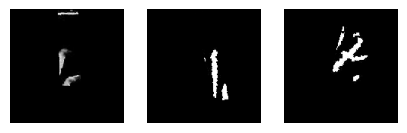

<Figure size 640x480 with 0 Axes>

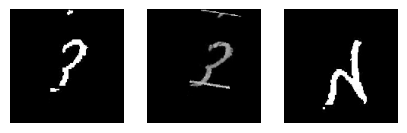

<Figure size 640x480 with 0 Axes>

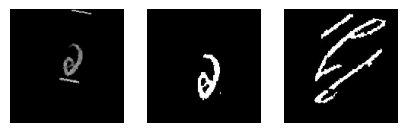

<Figure size 640x480 with 0 Axes>

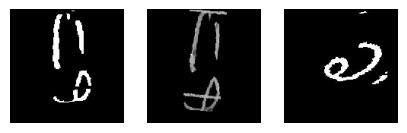

<Figure size 640x480 with 0 Axes>

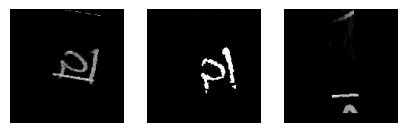

<Figure size 640x480 with 0 Axes>

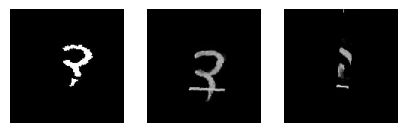

<Figure size 640x480 with 0 Axes>

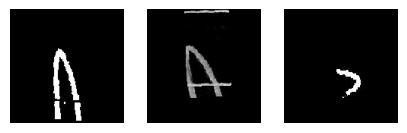

<Figure size 640x480 with 0 Axes>

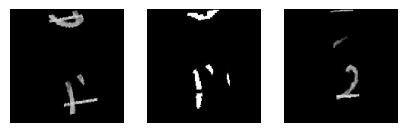

<Figure size 640x480 with 0 Axes>

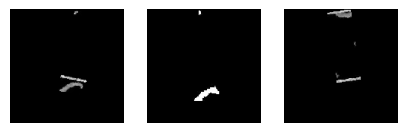

<Figure size 640x480 with 0 Axes>

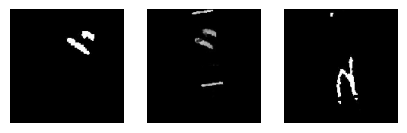

<Figure size 640x480 with 0 Axes>

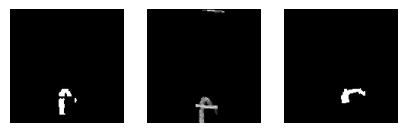

<Figure size 640x480 with 0 Axes>

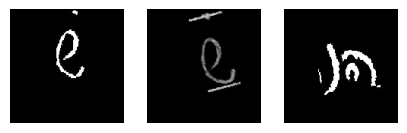

<Figure size 640x480 with 0 Axes>

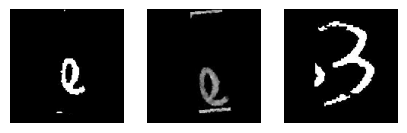

<Figure size 640x480 with 0 Axes>

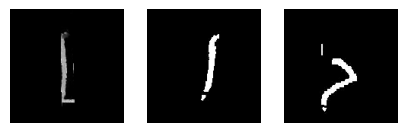

<Figure size 640x480 with 0 Axes>

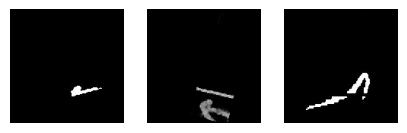

<Figure size 640x480 with 0 Axes>

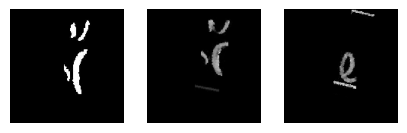

<Figure size 640x480 with 0 Axes>

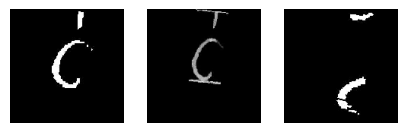

<Figure size 640x480 with 0 Axes>

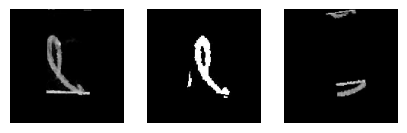

<Figure size 640x480 with 0 Axes>

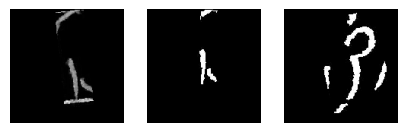

<Figure size 640x480 with 0 Axes>

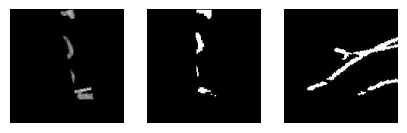

<Figure size 640x480 with 0 Axes>

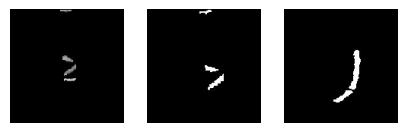

<Figure size 640x480 with 0 Axes>

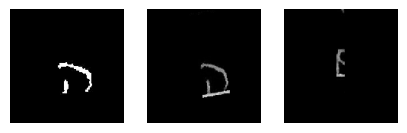

<Figure size 640x480 with 0 Axes>

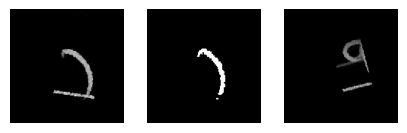

<Figure size 640x480 with 0 Axes>

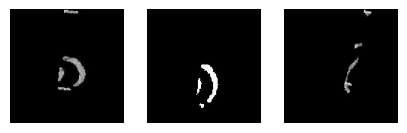

<Figure size 640x480 with 0 Axes>

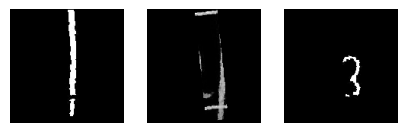

<Figure size 640x480 with 0 Axes>

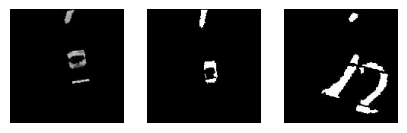

<Figure size 640x480 with 0 Axes>

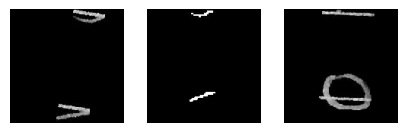

<Figure size 640x480 with 0 Axes>

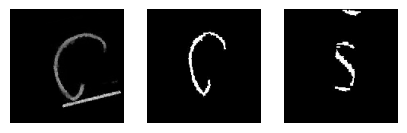

<Figure size 640x480 with 0 Axes>

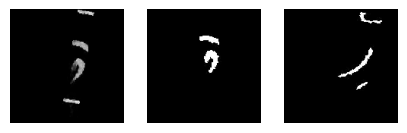

<Figure size 640x480 with 0 Axes>

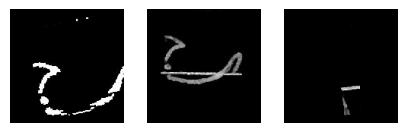

<Figure size 640x480 with 0 Axes>

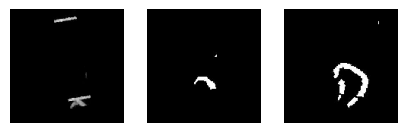

<Figure size 640x480 with 0 Axes>

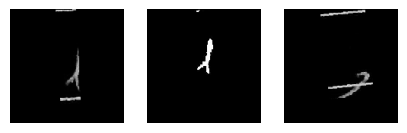

<Figure size 640x480 with 0 Axes>

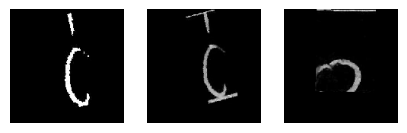

<Figure size 640x480 with 0 Axes>

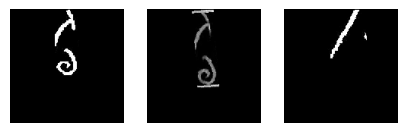

<Figure size 640x480 with 0 Axes>

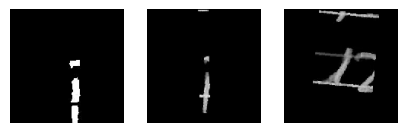

<Figure size 640x480 with 0 Axes>

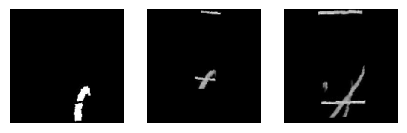

<Figure size 640x480 with 0 Axes>

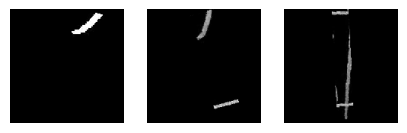

<Figure size 640x480 with 0 Axes>

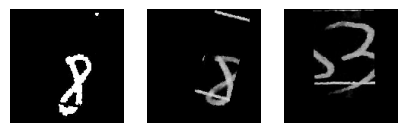

<Figure size 640x480 with 0 Axes>

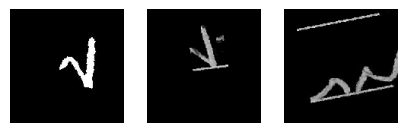

<Figure size 640x480 with 0 Axes>

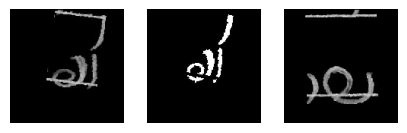

<Figure size 640x480 with 0 Axes>

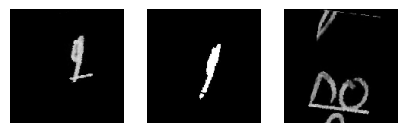

<Figure size 640x480 with 0 Axes>

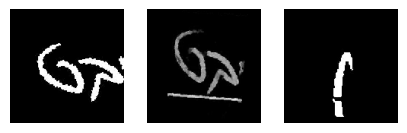

<Figure size 640x480 with 0 Axes>

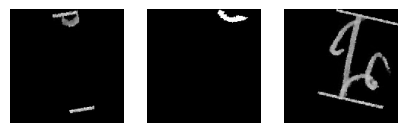

<Figure size 640x480 with 0 Axes>

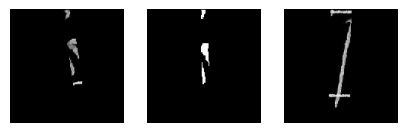

<Figure size 640x480 with 0 Axes>

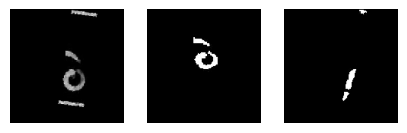

<Figure size 640x480 with 0 Axes>

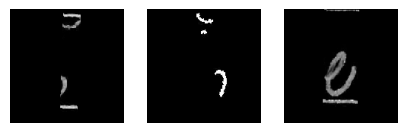

<Figure size 640x480 with 0 Axes>

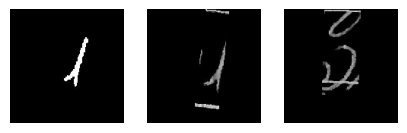

<Figure size 640x480 with 0 Axes>

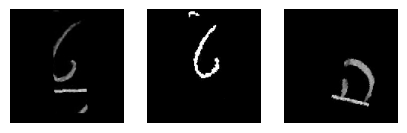

<Figure size 640x480 with 0 Axes>

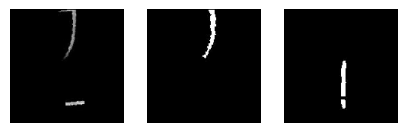

<Figure size 640x480 with 0 Axes>

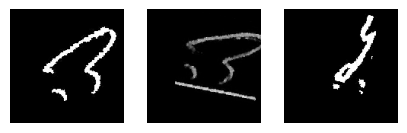

<Figure size 640x480 with 0 Axes>

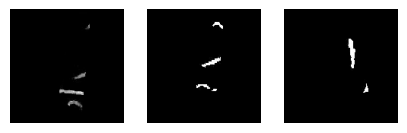

<Figure size 640x480 with 0 Axes>

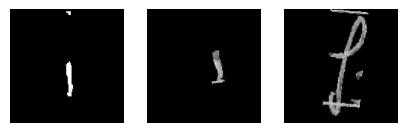

<Figure size 640x480 with 0 Axes>

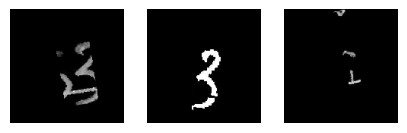

<Figure size 640x480 with 0 Axes>

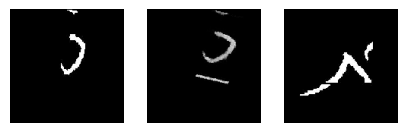

<Figure size 640x480 with 0 Axes>

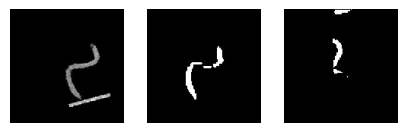

<Figure size 640x480 with 0 Axes>

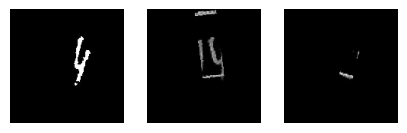

<Figure size 640x480 with 0 Axes>

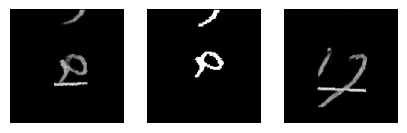

<Figure size 640x480 with 0 Axes>

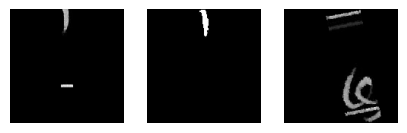

<Figure size 640x480 with 0 Axes>

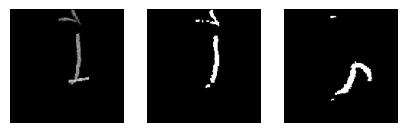

<Figure size 640x480 with 0 Axes>

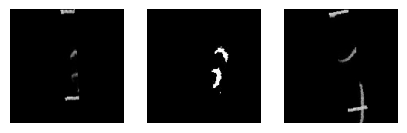

<Figure size 640x480 with 0 Axes>

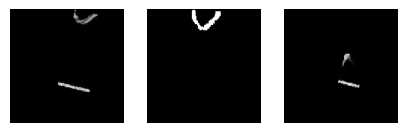

<Figure size 640x480 with 0 Axes>

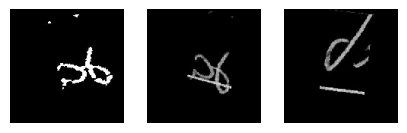

<Figure size 640x480 with 0 Axes>

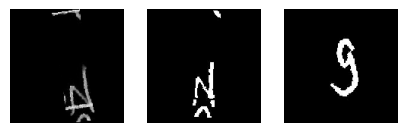

<Figure size 640x480 with 0 Axes>

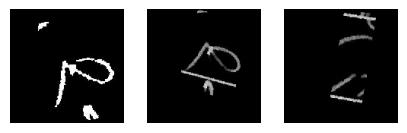

<Figure size 640x480 with 0 Axes>

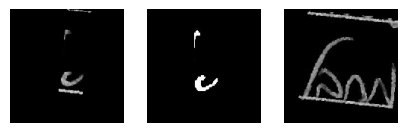

<Figure size 640x480 with 0 Axes>

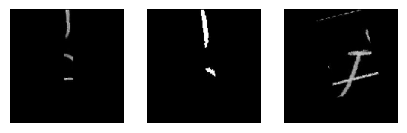

<Figure size 640x480 with 0 Axes>

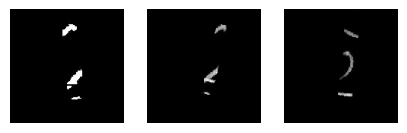

<Figure size 640x480 with 0 Axes>

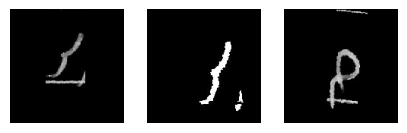

<Figure size 640x480 with 0 Axes>

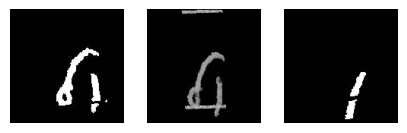

<Figure size 640x480 with 0 Axes>

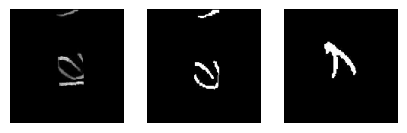

<Figure size 640x480 with 0 Axes>

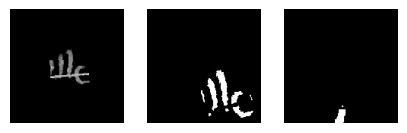

<Figure size 640x480 with 0 Axes>

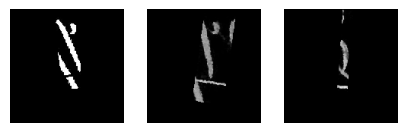

<Figure size 640x480 with 0 Axes>

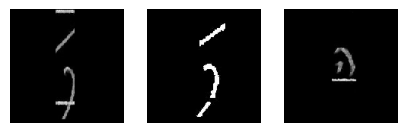

<Figure size 640x480 with 0 Axes>

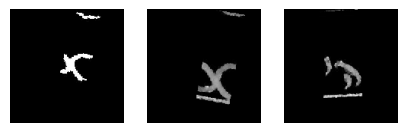

<Figure size 640x480 with 0 Axes>

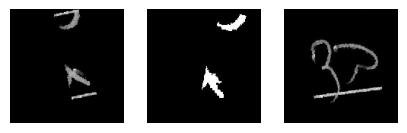

<Figure size 640x480 with 0 Axes>

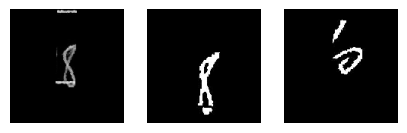

<Figure size 640x480 with 0 Axes>

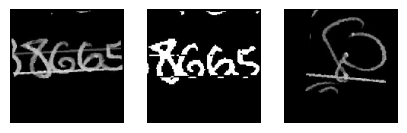

<Figure size 640x480 with 0 Axes>

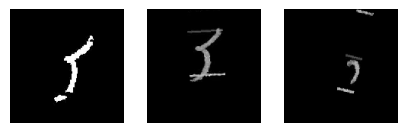

select_users_chunk 10 out of 200 
selected user_ids [186, 163, 31, 164, 167, 100, 106, 156, 64, 141]
running GarbageCollector...


In [ ]:
def display_triplets():

  train_gen = TripletsGenerator(MODE_TRAIN, user_ids, model_options)
  valid_gen = TripletsGenerator(MODE_VALIDATION, user_ids, model_options)

  train_gen.on_epoch_end()
  for i, batch_x in enumerate(train_gen):
    anchors, possitives, negatives = batch_x[0]
    for i in range(len(anchors)):
        show_triplet([anchors[i], possitives[i],negatives[i]])

    if i==5:
      break
    break
    #for id, letter in enumerate(batch_x):
    #  print(labels[id])
    #  #image_dots(letter.squeeze()*255)
    #  show_line(letter.squeeze())
    #break


    #break
  train_gen.on_epoch_end()

full_data_set = DataSet()
display_triplets()

In [ ]:
def display_letters():
  train_gen = LettersGenerator(MODE_TRAIN, user_ids, model_options, len(user_ids))
  valid_gen = LettersGenerator(MODE_VALIDATION, user_ids, model_options, len(user_ids))

  train_gen.on_epoch_end()
  for i, (batch_x, labels) in enumerate(train_gen):
    #print(labels)
    #pass
    show_sequence(batch_x)
    if i==5:
      break
    #for id, letter in enumerate(batch_x):
    #  print(labels[id])
    #  image_dots(letter.squeeze()*255)
    #  if i==10:
    #    break

    #  show_line(letter.squeeze())
    #break

  train_gen.on_epoch_end()

#full_data_set = DataSet()
display_letters()

In [ ]:

from numba import cuda
device = cuda.get_current_device()
device.reset()


# **Incremental learning**

Resnet for embedding

In [11]:
class EmbeddingModel:

    def get_model(self, input_shape, embedding_dim):
        model = Sequential()
        model.add(Input(shape=input_shape))
        # Convolutional layers
        model.add(Conv2D(input_shape=input_shape,
                         filters=32, kernel_size=(11, 11), padding='SAME', activation='relu',
                         kernel_regularizer=l2(2e-4),
                         kernel_initializer='he_uniform'
                         ))
        model.add(MaxPooling2D((3, 3)))
        model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='SAME', activation='relu'))
        model.add(MaxPooling2D((3, 3)))
        model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation='relu'))
        model.add(MaxPooling2D((3, 3)))
        model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation='relu'))
        model.add(MaxPooling2D((3, 3)))
        # model.add(Conv2D(64, (1, 1), activation='relu'))
        model.add(Flatten())
        # model.add(Dense(1024, activation='relu',
        # kernel_regularizer=l2(1e-3),
        # kernel_initializer='he_uniform'
        #           ))
        model.add(Dense(embedding_dim, activation='relu',
                        kernel_regularizer=l2(1e-3),
                        kernel_initializer='he_uniform'
                        ))
        model.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))

        return model


In [ ]:

input_shape = (model_options.image_height, model_options.image_width, 1)
embedding_network = EmbeddingModel().get_model(embedding_dim=model_options.embedding_dim , input_shape=input_shape)


embedding_network.summary()

NameError: ignored

# **Model for generating embedding vector (128) for user letters image**

In [12]:
class SiameseModel:
    def __init__(self, options: ModelOptions, embedding):
        super().__init__()
        self.options = options
        self.alpha = options.alpha
        input_shape = (model_options.image_height,model_options.image_width ,1)
        self.embedding = embedding

    def get_model(self):
      #triplet_input = Input(shape=(self.options.image_height, self.options.image_width, 1), name='triplet_input')

      input_shape = (model_options.image_height,model_options.image_width ,1)
      anchor_input = Input(input_shape, name="anchor_input")
      positive_input = Input(input_shape, name="positive_input")
      negative_input = Input(input_shape, name="negative_input")

      #anchor_input = Lambda(lambda x: x[0])(triplet_input)
      #positive_input = Lambda(lambda x: x[1])(triplet_input)
      #negative_input = Lambda(lambda x: x[2])(triplet_input)

      enc_anchor = self.embedding(anchor_input)
      enc_positive = self.embedding(positive_input)
      enc_negative = self.embedding(negative_input)

      loss_layer = TripletLossLayer(alpha=self.alpha, name='triplet_loss_layer')([enc_anchor, enc_positive, enc_negative])

      model = Model(inputs=[anchor_input,positive_input,negative_input],outputs= loss_layer)
      return model
    def get_embedding(self):
      return self.embedding

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)

    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)

    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss



In [27]:
full_data_set = DataSet()
filepath = MODEL_CHECKPOINT_PATH + "siamese-model-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

num_epochs=20
user_ids =[i for i in range(0,200)]

model_options = ModelOptions(
    num_classes=len(user_ids),
    batch_size=100,
    random_shuffle_amount=1,
    alpha = 0.2,
    embedding_dim=128
)

num_classes = model_options.num_classes
train_gen = TripletsGenerator(MODE_TRAIN, user_ids, model_options)
valid_gen = TripletsGenerator(MODE_VALIDATION, user_ids, model_options)
input_shape = (model_options.image_height,model_options.image_width ,1)
embedding_network = EmbeddingModel().get_model(embedding_dim=model_options.embedding_dim , input_shape=input_shape)
sm_network = SiameseModel(model_options, embedding_network)
model = sm_network.get_model()
opt =  Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss=None)
model.summary()


select_users_chunk 10 out of 200 
selected user_ids [196, 185, 54, 68, 45, 32, 191, 108, 171, 98]
select_users_chunk 10 out of 200 
selected user_ids [70, 36, 58, 82, 110, 196, 2, 93, 168, 31]
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                 

In [ ]:

plot_model(model,show_shapes=True, show_layer_names=True)
history = model.fit(train_gen, epochs=num_epochs,batch_size=model_options.batch_size,
#                   validation_data=valid_gen, verbose=1)
                    verbose=1, callbacks=callbacks_list)


select_users_chunk 10 out of 200 
selected user_ids [151, 98, 127, 174, 109, 150, 27, 95, 25, 194]
select_users_chunk 10 out of 200 
selected user_ids [159, 169, 104, 138, 155, 194, 107, 128, 40, 79]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                            

continue training

In [28]:
full_data_set = DataSet()
user_ids =[i for i in range(0,200)]


num_epochs=2
model.load_weights(MODEL_CHECKPOINT_PATH+'siamese-model-02-0.44.hdf5')
history = model.fit(train_gen, epochs=num_epochs,batch_size=model_options.batch_size,
#                   validation_data=valid_gen, verbose=1)
                    verbose=1, callbacks=callbacks_list)


loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines3_Page_60.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines3_Page_60.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines3_Page_65.jpgloading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines3_Page_65.jpg

loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines3_Page_38.jpgloading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines3_Page_38.jpg

loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines2_Page_03.jpgloading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines2_Page_03.jpg

loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines1_Page_57.jpg
loading image from /g

In [ ]:
sm_network.embedding.get_weights()

In [32]:
embedding = sm_network.embedding

In [36]:
featured_img = embedding.predict(np.ones((1,150,150,1)))
print(featured_img)


1/1 [==============================] - 0s 18ms/step
[[0.         0.         0.19956462 0.         0.         0.
  0.         0.08166576 0.         0.         0.         0.
  0.         0.         0.         0.         0.04982999 0.
  0.         0.         0.         0.         0.         0.
  0.         0.09193456 0.         0.12903051 0.         0.
  0.         0.         0.         0.         0.         0.
  0.04491463 0.         0.         0.         0.         0.
  0.         0.         0.03896184 0.11962152 0.         0.13373402
  0.         0.         0.         0.         0.         0.
  0.         0.0119505  0.17228322 0.35380846 0.         0.
  0.         0.         0.08986016 0.         0.         0.
  0.         0.         0.         0.         0.01708948 0.
  0.09947041 0.05610473 0.00496974 0.         0.07247635 0.
  0.         0.46115816 0.         0.         0.0174354  0.
  0.         0.         0.03451794 0.         0.04593088 0.
  0.         0.         0.         0.   

# **EMBEDDING + LSTM + ATTENTION Classfication**

In [39]:
class SequenceGenerator(Sequence):

    def __init__(self, mode, user_ids, model_options: ModelOptions):
        self.options = model_options
        self.user_ids = [i for i in user_ids]
        self.id_to_class = {user_id: i for i, user_id in enumerate(user_ids)}
        self.input_shape = (model_options.image_height, model_options.image_width)
        self.usage_stats = {}
        self.num_classes = model_options.num_classes
        self.users_ds = {}
        self.generators = {}
        self.mode = mode

    def on_epoch_end(self):
        self.generators = {}

    def incr_usage(self, user_id):
        if user_id not in self.usage_stats:
            self.usage_stats[user_id] = 0
        self.usage_stats[user_id] += 1

    def max_usages_per_user(self):
        lines = 50
        return lines * self.options.random_shuffle_amount

    def get_user_ds(self, user_id):
        if user_id not in self.users_ds:
            uds = UserDataset(user_id)
            uds.warmup(load_types=[LINES_REMOVED_BW_IMAGES, LINES_REMOVED_IMAGES])
            self.users_ds[user_id] = uds
        self.incr_usage(user_id)
        return self.users_ds[user_id]

    def get_sequence_generator(self, user_id):
        if user_id not in self.generators:
            #print(f"new generator for {user_id}")
            uds = self.get_user_ds(user_id)
            self.generators[user_id] = uds.random_line_generator(mode=self.mode,
                                                                 max_sequence_length=self.options.max_sequence_length,
                                                                 target_size=self.input_shape)
        return self.generators[user_id]

    def __len__(self):
        lines = 20
        users = len(self.user_ids)
        random_shuffle_amount = self.options.random_shuffle_amount
        types = len(ALLOWED_TYPES)

        total_batches = (types * lines * users * random_shuffle_amount) // self.options.batch_size
        return total_batches

    def __getitem__(self, index):
        batch, labels = [], []
        for s in range(self.options.batch_size):
            user_id = random.choice(self.user_ids)
            sequence = next(self.get_sequence_generator(user_id))
            batch.append(sequence)
            labels.append(to_categorical(self.id_to_class[user_id], num_classes=self.options.num_classes))

        return np.asarray(batch), np.asarray(labels)

In [40]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Input, AdditiveAttention, Flatten

class CnnLstmAttentionModel:
    def __init__(self, options: ModelOptions, embedding_model):
        self.model_options = options
        self.embedding_model = embedding_model



    def get_model(self, options):
        input_layer = Input(shape=(self.model_options.max_sequence_length, self.model_options.image_height,
                                   self.model_options.image_width, 1))

        # 2) Use the CustomCNN as the embedding
        self.embedding_model.trainable = False

        # Apply CustomCNN to each image in the sequence
        sequence_embedding = TimeDistributed(self.embedding_model)(input_layer)

        # Flatten the output of the CustomCNN model
        flattened_sequence = TimeDistributed(tf.keras.layers.Flatten())(sequence_embedding)

        # LSTM Layer
        lstm_output = LSTM(options['lstm_units'])(flattened_sequence)

        # Additive Attention Layer
        attention_output = AdditiveAttention()([lstm_output, lstm_output])

        # Flattening the output for the Dense layer
        attention_output_flat = Flatten()(attention_output)

        dense_output = Dense(options['dense_units'], activation='relu')(attention_output_flat)

        # 5) Classification Layer
        output = Dense(options['num_classes'], activation='softmax')(dense_output)

        # Build the model
        model = Model(inputs=input_layer, outputs=output)

        return model

    def _convert_to_embedding_model(self, base_model, layer_name):
        return Model(base_model.inputs, base_model.get_layer(layer_name).output)

In [41]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

filepath = MODEL_CHECKPOINT_PATH + "cnnlstm-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

num_epochs = 10


model_options.max_sequence_length=50
model_options.random_shuffle_amount = 1

layers_options = {
    'lstm_units': 10,
    'dense_units': 4,
    'num_classes': model_options.num_classes
}




print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# If a GPU is available, the TensorFlow should default to it
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

input_shape = (model_options.image_height, model_options.image_width, 1)
num_classes = len(user_ids)
train_gen = SequenceGenerator(MODE_TRAIN, user_ids, model_options)
valid_gen = SequenceGenerator(MODE_VALIDATION, user_ids, model_options)



Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [42]:
sm = CnnLstmAttentionModel(model_options,embedding)
model = sm.get_model(layers_options)

opt =  Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_gen, epochs=num_epochs, batch_size=model_options.batch_size,
                    validation_data=valid_gen, verbose=1, callbacks=callbacks_list)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 50, 150, 15  0           []                               
                                0, 1)]                                                            
                                                                                                  
 time_distributed_2 (TimeDistri  (None, 50, 128)     457088      ['input_10[0][0]']               
 buted)                                                                                           
                                                                                                  
 time_distributed_3 (TimeDistri  (None, 50, 128)     0           ['time_distributed_2[0][0]']     
 buted)                                                                                     

IndexError: ignored

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

CNN NETWORK - from per image classification - DON'T USE IT

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input


class CustomCNN:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def get_model(self, options):
        model = Sequential()
        model.add(Input(shape=self.input_shape))

        # Adding Convolutional Layers
        for i in range(options['depth']):
            print(f"model.add(Conv2D(filters={options['filters'][i]}, kernel_size={options['kernel_sizes'][i]},strides={options['strides'][i]},padding={options['padding'][i]}))")
            model.add(Conv2D(filters=options['filters'][i],
                             kernel_size=options['kernel_sizes'][i],
                             strides=options['strides'][i],
                             padding=options['padding'][i]))
            print(f"model.add(Activation({options['conv_activation']}))")
            model.add(Activation(options['conv_activation']))
            if options['pooling'][i]:
                print(f"model.add(MaxPooling2D(pool_size={options['pool_sizes'][i]}, strides={options['pool_strides'][i]}))")
                model.add(MaxPooling2D(pool_size=options['pool_sizes'][i],
                                       strides=options['pool_strides'][i]))
        print(f"Flatten()")
        model.add(Flatten())  # Flattening the 2D arrays for fully connected layers

        # Adding Fully Connected Layers
        for i in range(options['fc_layers']):
            print(f"model.add(Dense({options['fc_units'][i]}))")
            model.add(Dense(options['fc_units'][i]))
            print(f"model.add(Activation({options['fc_activation']}))")
            model.add(Activation(options['fc_activation']))
            print(f"model.add(Dropout({options['dropout_rate']}))")
            model.add(Dropout(options['dropout_rate']))

        # Output Layer
        print(f"model.add(Dense({options['num_classes']}, activation='softmax'))")
        model.add(Dense(options['num_classes'], activation='softmax'))

        return model




In [ ]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate

  def __call__(self, step):
     return self.initial_learning_rate / (step + 1)


In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = MODEL_CHECKPOINT_PATH + "model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

num_epochs=10
#user_ids =[i for i in range(1,5)]

model_options = ModelOptions(
    num_classes=len(user_ids),
    batch_size=100,
    image_height=150,
    image_width=150,
    num_channels=1,
    max_sequence_length=40,
    random_shuffle_amount=2
)

layers_options = {
    'depth':5,  # number of convolutional layers
    'filters': [32,64,128,256,512],  # number of filters for each conv layer
    'kernel_sizes': [(10,10),(5,5), (3,3), (3,3), (1,1 )],  # filter sizes
    'strides': [(3, 3),(3, 3),(1, 1),(3, 3),(1, 1)],  # strides for each conv layer
    'padding': [ 'same','same','same','same','same' ],  # padding for each conv layer
    'conv_activation': 'relu',  # activation function for the convolutional layers
    'pooling': [True,True,True,False,False],  # whether to include a pooling layer after each conv layer
    'pool_sizes': [(3, 3),(3, 3),(3, 3),(3, 3)],  # sizes of the pooling filters
    'pool_strides': [(2, 2),(2, 2),(2, 2),(2, 2),(2, 2)],  # strides for each pooling layer
    'fc_layers': 1,  # number of fully connected layers
    'fc_units': [256],  # number of units in each fully connected layer
    'fc_activation': 'relu',  # activation function for the fully connected layers
    'dropout_rate': 0.2,  # dropout rate
    'num_classes':model_options.num_classes   # number of classes in the output layer
}

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# If a GPU is available, the TensorFlow should default to it
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")



input_shape = (model_options.image_height,model_options.image_width ,1)
num_classes = model_options.num_classes





Num GPUs Available:  0
Please install GPU version of TF


In [ ]:
user_ids = [random.randint(1,40),random.randint(41,80),random.randint(81,120)]
train_gen = LettersGenerator(MODE_TRAIN,user_ids, model_options)
valid_gen = LettersGenerator(MODE_VALIDATION, user_ids, model_options)

In [ ]:
sm = CustomCNN(input_shape)
model = sm.get_model(layers_options)

opt =  Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_gen, epochs=num_epochs, batch_size=model_options.batch_size,
                   validation_data=valid_gen, verbose=1)
#                   validation_data=valid_gen, verbose=1, callbacks=callbacks_list)

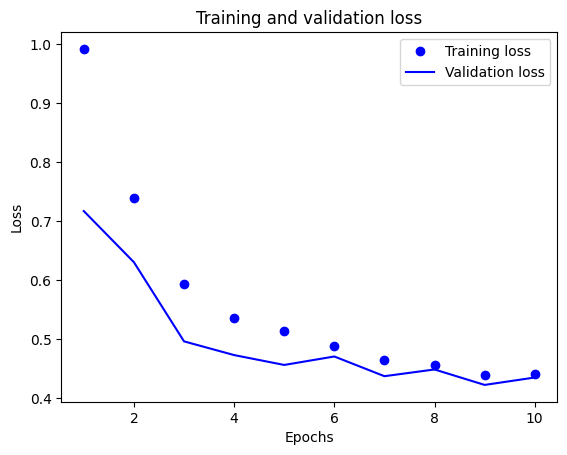

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc  = history_dict['accuracy']
epochs = range(1, len(acc) + 1)
plt.clf()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

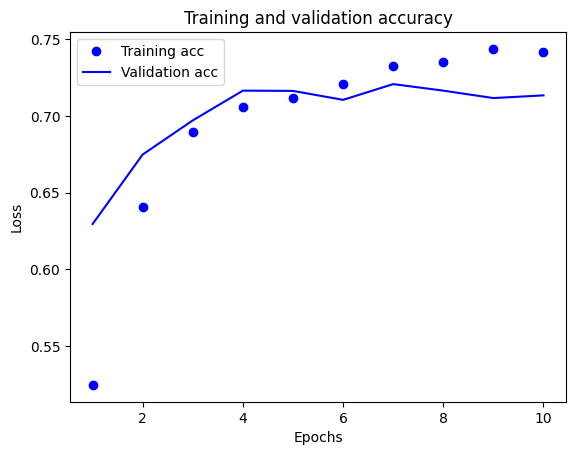

In [ ]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
from keras import backend as K
filepath = MODEL_CHECKPOINT_PATH + 'model-15-0.41.hdf5'
# load the model
loaded_model = load_model(filepath)
K.set_value(loaded_model.optimizer.lr,1e-6)
loaded_model.summary()
history = loaded_model.fit(train_gen, epochs=num_epochs, batch_size=model_options.batch_size,
                    validation_data=valid_gen, verbose=1, callbacks=callbacks_list)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 35, 35, 96)        11712     
                                                                 
 activation_9 (Activation)   (None, 35, 35, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 17, 17, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 256)       614656    
                                                                 
 activation_10 (Activation)  (None, 17, 17, 256)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                  

KeyboardInterrupt: ignored